# OT GAN

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


## Imports

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np
from time import time
from tqdm.notebook import tqdm
import datetime as dt

## Utils

### Loading data

In [ ]:
class MyDataLoader():
    """
    A custom data loader class, allowing us to create a data loader for MNIST
    or CIFAR-10 with the desired batch size. It is also possible to keep only
    some of the classes.

    Parameters
    ----------
    dataset : str
        Name of a supported dataset (MNIST or CIFAR10)
    batch_size : int, optional
        Batch size of the data loader. Note that for OT GAN, the mini_batch size 
        will be a half of batch size.
    filters: list of int, optional
        List containing the indices of the classes we want to retain in our
        dataset. If empty, each class will be used.
    """

    def __init__(self, dataset='CIFAR10', batch_size=64, filters=[]):
        self.dataset = dataset
        self.batch_size = batch_size
        self.init_transformer()
        self.init_dataset(filters)

    def init_dataset(self, filters, num_workers=1):

        if (self.dataset == 'CIFAR10'):
            data_train = torchvision.datasets.CIFAR10(root='./data', train=True,
                                      download=True, transform=self.transformer)
            
            # Remark: the test set is not useful for our application, but one
            #  could reuse the following code for another application.
            data_test = torchvision.datasets.CIFAR10(root='./data', train=False,
                                      download=True, transform=self.transformer)
            
            if (filters):
                train_mask = np.isin(data_train.targets, filters)
                data_train.data = data_train.data[train_mask]
                data_train.targets = (np.array(data_train.targets)[train_mask]).tolist()
                
                test_mask = np.isin(data_test.targets, filters)
                data_test.data = data_test.data[test_mask]
                data_test.targets = (np.array(data_test.targets)[test_mask]).tolist()
                

            loader_train = torch.utils.data.DataLoader(data_train, 
                                                       batch_size=self.batch_size,
                                                       shuffle=True, 
                                                       num_workers=num_workers)
            loader_test = torch.utils.data.DataLoader(data_test, 
                                                      batch_size=self.batch_size,
                                                      shuffle=False, 
                                                      num_workers=num_workers)
            classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 
                       'horse', 'ship', 'truck')
            
        elif (self.dataset == 'MNIST'):
            data_train = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True, transform=self.transformer)
            data_test = torchvision.datasets.MNIST(root='./data', train=False,
                                        download=True, transform=self.transformer)
            
            if (filters):
                train_mask = np.isin(data_train.targets, filters)
                data_train.data = data_train.data[train_mask]
                data_train.targets = (np.array(data_train.targets)[train_mask]).tolist()
                
                test_mask = np.isin(data_test.targets, filters)
                data_test.data = data_test.data[test_mask]
                data_test.targets = (np.array(data_test.targets)[test_mask]).tolist()
            
            loader_train = torch.utils.data.DataLoader(data_train, 
                                                       batch_size=self.batch_size,
                                                       shuffle=True, 
                                                       num_workers=num_workers)
            loader_test = torch.utils.data.DataLoader(data_test, 
                                                      batch_size=self.batch_size,
                                                      shuffle=False, 
                                                      num_workers=num_workers)
            classes = ('0', '1', '2', '3', '4', '5', '6', '7', '8', '9')
            
        else:
            print('Unkown dataset.')
            return None
            
        self.loader_train = loader_train
        self.loader_test = loader_test
        self.classes = classes

    def init_transformer(self):
      
        if (self.dataset =='CIFAR10'):
            transformer = transforms.Compose([transforms.ToTensor(),
                 transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
        elif (self.dataset=='MNIST'):
            transformer = transforms.Compose(
                [transforms.ToTensor(), transforms.Normalize((0.5), (0.5))])
            
        self.transformer = transformer

### Plots

In [ ]:
# Some functions to make visualization easier
def imshow(img):
    """ To plot one single image. """
    plt.figure(figsize=(16, 8))
    img = img / 2 + 0.5     # unnormalize (see transforms above)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

    ax = plt.gca()
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    plt.show()

def img_grid(data, labels, classes, nb_img, nrow=16):
    """ To plot a grid of images, and the labels (if known). """

    # if only a few images
    nrow = min(nb_img, nrow)

    # show images
    imshow(torchvision.utils.make_grid(data[:nb_img], nrow=nrow, padding=0))
    
    # show labels if passed
    if (labels != None and classes != None):
        for i in range(0, nb_img, nrow):
            string = ' | '.join('%5s' % classes[labels[j]] for j in range(i, (i+nrow)))
            print(string)
        
    return None


In [ ]:
# To check if everything is working
dataset = 'MNIST' # or CIFAR10
filters = []
loader = MyDataLoader(dataset, filters=filters)

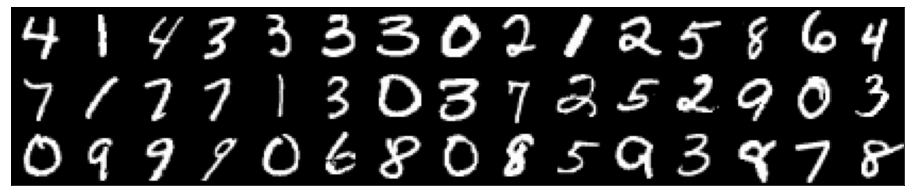

    4 |     1 |     4 |     3 |     3 |     3 |     3 |     0 |     2 |     1 |     2 |     5 |     8 |     6 |     4
    7 |     1 |     7 |     7 |     1 |     3 |     0 |     3 |     7 |     2 |     5 |     2 |     9 |     0 |     3
    0 |     9 |     9 |     9 |     0 |     6 |     8 |     0 |     8 |     5 |     9 |     3 |     8 |     7 |     8


In [ ]:
data_iter = iter(loader.loader_train)
images, labels = data_iter.next()
classes = loader.classes

img_grid(images, labels, classes, 45, 15)

## Models

### OT GAN

#### OT Generator & Critic

In [ ]:
class OT_Generator(nn.Module):
    """
    An implementation of the Generator described in "Improving GANs using
    optimal transport" by T.Salimans et al (2018).

    Parameters
    ----------
    img_shape : tuple (int, int, int)
        Shape of the images in the dataset. Any shape should work (works at 
        least with MNIST and CIFAR-10).
    dim_z : int, optional
        Dimension of the uniform distribution between -1 and 1, from which the
        generator will return a generated image.
    n_features_G: int, optional
        Parameter allowing us to change the number of parameters (allowing us
        to scale the generator depending on the dataset). The value 128 matches 
        the parameters given in the paper. 

    """
    def __init__(self, img_shape=(3,32,32), dim_z=100, n_features_G=128):
        super(OT_Generator, self).__init__()
        
        ### PARAMETERS ###

        self.img_shape = img_shape
        self.dim_z = dim_z
        self.n_features_G = n_features_G
        
        channels = img_shape[0]
        kernel_size = 5
        pad = (kernel_size - 1) // 2
        
        ### LAYERS ###
        
        # Linear layer; output if default param.: (dim_z, 16384) 
        self.linear = nn.Linear(dim_z, 2*((8*n_features_G)*4*4)) # x2 for GLU

        # 2x2 nearest-neighbor upsampling operations
        self.upspl = nn.Upsample(scale_factor=2, mode='nearest')
        self.upspl_out = nn.Upsample(size=[img_shape[1], img_shape[2]])

        # Activations
        self.glu = nn.GLU(dim=1)
        self.tanh = nn.Tanh()

        # Convolution layers
        self.conv1 = nn.Conv2d(in_channels=8*n_features_G, 
                               out_channels=2*(4*n_features_G), # x2 for GLU
                               kernel_size=kernel_size, 
                               stride=1, 
                               padding=pad, 
                               bias=False)
        self.conv2 = nn.Conv2d(4*n_features_G, 2*(2*n_features_G), kernel_size,
                               1, padding=pad, bias=False)
        self.conv3 = nn.Conv2d(2*n_features_G, 2*(n_features_G), kernel_size, 1, 
                               padding=pad, bias=False) 
        self.conv4 = nn.Conv2d(n_features_G, channels, kernel_size, 1, 
                               padding=pad, bias=False) 
        
        ### OPTIMIZER ###
        self.optim = optim.Adam(self.parameters(), lr=3e-4, betas=(0.5, 0.999))

    def forward(self, inputs):
        img_size = self.img_shape[1] * self.img_shape[2]
        x = self.glu(self.linear(inputs))           # L0: shape=(batch, 16384)
        x = torch.reshape(x, (-1, 8*self.n_features_G, 4, 4))
        x = self.glu(self.conv1(self.upspl(x)))     # L1: shape=(batch, 512, 8, 8)
        x = self.glu(self.conv2(self.upspl(x)))     # L2: shape=(batch, 256, 16, 16)
        x = self.glu(self.conv3(self.upspl_out(x))) # L3: shape=(batch, 128, 32, 32)
        x = self.tanh(self.conv4(x))                # L4: shape=(batch, 3, 32, 32)

        assert x.shape[1:] == torch.Size(self.img_shape)
        return x

    def load_weights(self, weights=None):
        """
        Loads the weights from a previous training if a path is passed,
        otherwise initializes them properly before training.
        """
        if weights:
            self.load_state_dict(torch.load(weights, map_location='cpu'))
        else:
            self.apply(self.weights_init)

    def weights_init(self, m):
        classname = m.__class__.__name__
        if classname.find('Conv') != -1:
            nn.init.normal_(m.weight.data, 0.0, 0.02)
        elif classname.find('BatchNorm') != -1:
            nn.init.normal_(m.weight.data, 1.0, 0.02)
            nn.init.constant_(m.bias.data, 0)

In [ ]:
class OT_Critic(nn.Module):
    """
    An implementation of the Critic described in "Improving GANs using
    optimal transport" by T.Salimans et al (2018).

    Parameters
    ----------
    img_shape : tuple (int, int, int)
        Shape of the images in the dataset. Any shape should work (works at 
        least with MNIST and CIFAR-10).
    n_features_C: int, optional
        Parameter allowing us to change the number of parameters (allowing us
        to scale the generator depending on the dataset). The value 128 matches 
        the parameters given in the paper. 

    """

    def __init__(self, img_shape=(3,32,32), n_features_C=128):
        super(OT_Critic, self).__init__()
    
        ### PARAMETERS ###
        
        self.img_shape = img_shape
        self.n_features_C = n_features_C
        
        channels = img_shape[0]
        kernel_size = 5
        pad = (kernel_size - 1) // 2

        ### LAYERS ###
        
        self.conv0 = nn.Conv2d(in_channels=channels, 
                               out_channels=n_features_C, 
                               kernel_size=kernel_size, 
                               stride=1, 
                               padding=pad, 
                               bias=False)
        self.conv1 = nn.Conv2d(2*n_features_C, 2*n_features_C, kernel_size, 2,
                               padding=pad, bias=False)
        self.conv2 = nn.Conv2d(4*n_features_C, 4*n_features_C, kernel_size, 2,
                               padding=pad, bias=False)
        self.conv3 = nn.Conv2d(8*n_features_C, 8*n_features_C, kernel_size, 2,
                               padding=pad, bias=False)

        self.activ = CReLU()

        ### OPTIMIZER ###
        self.optim = optim.Adam(self.parameters(), lr=3e-4, betas=(0.5, 0.999))
        

    def forward(self, input):
        x = self.activ(self.conv0(input)) # L0: shape = (batch, 256, 32, 32)
        x = self.activ(self.conv1(x)) # L1: shape = (batch, 512, 16, 16)
        x = self.activ(self.conv2(x)) # L2: shape = (batch, 1024, 8, 8)
        x = self.activ(self.conv3(x)) # L3: shape = (batch, 2048, 4, 4)
        dim2, dim3 = x.shape[2], x.shape[3]
        x = torch.reshape(x, (-1, (8*self.n_features_C) * 2 * dim2 * dim3))
        x = nn.functional.normalize(x, p=2, dim=-1) # L2 normalization

        assert x.shape[1] == (8*self.n_features_C) * 2 * dim2 * dim3
        return x

    def set_optimizer(self, optimizer):
        self.optim = optimizer

    def load_weights(self, weights=None):
        """
        Loads the weights from a previous training if a path is passed,
        otherwise initializes them properly before training.
        """
        if weights:
            self.load_state_dict(torch.load(weights, map_location='cpu'))
        else:
            self.apply(self.weights_init)

    def weights_init(self, m):
        classname = m.__class__.__name__
        if classname.find('Conv') != -1:
            nn.init.normal_(m.weight.data, 0.0, 0.02)
        elif classname.find('BatchNorm') != -1:
            nn.init.normal_(m.weight.data, 1.0, 0.02)
            nn.init.constant_(m.bias.data, 0)

class CReLU(nn.Module):

    def __init__(self, inplace=False):
        super(CReLU, self).__init__()

    def forward(self, x):
        x = torch.cat((x,-x), 1)
        return nn.functional.relu(x)

#### Small tests

In [ ]:
# To check if it works

img_shape = (1, 32, 32) # TO CHANGE, HERE FOR MNIST
z = 2 * torch.rand(100) - 1 # uniform on (-1, 1)

generator = OT_Generator(img_shape)
print(generator.forward(z.reshape(1, -1)).shape)

critic = OT_Critic(img_shape=img_shape)
print(critic.forward(generator.forward(z.reshape(1, -1))).shape)

torch.Size([1, 1, 32, 32])
torch.Size([1, 32768])


In [ ]:
# Print the layers
print(generator)
print(critic)

OT_Generator(
  (linear): Linear(in_features=100, out_features=32768, bias=True)
  (upspl): Upsample(scale_factor=2.0, mode=nearest)
  (upspl_out): Upsample(size=[32, 32], mode=nearest)
  (glu): GLU(dim=1)
  (tanh): Tanh()
  (conv1): Conv2d(1024, 1024, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), bias=False)
  (conv2): Conv2d(512, 512, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), bias=False)
  (conv3): Conv2d(256, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), bias=False)
  (conv4): Conv2d(128, 1, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), bias=False)
)
OT_Critic(
  (conv0): Conv2d(1, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), bias=False)
  (conv1): Conv2d(256, 256, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), bias=False)
  (conv2): Conv2d(512, 512, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), bias=False)
  (conv3): Conv2d(1024, 1024, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), bias=False)
  (activ): CReLU()
)


#### OT GAN

In [ ]:
class OT_GAN(nn.Module):
    """
    An implementation of an Optimal Transport GAN described in "Improving GANs 
    using optimal transport" by T.Salimans et al (2018).

    Parameters
    ----------
    data_loader : Data Loader
        An instance of a pytorch data loader.
    generator : OT_Generator
        An instance of an OT_Generator.
    critic : OT_Critic
        An instance of an OT_Critic.
    device : str
        To perform the training either on cpu or on a single gpu.
    update_ratio : int
        The update ratio between the generator and the critic (1 out of 
        'update_ratio' updates is for the critic).

    """
    def __init__(self, data_loader, generator, critic, device, update_ratio=4):
        super(OT_GAN, self).__init__()

        self.data_train = data_loader.loader_train
        # We could also use testing data for our GAN. The code provided does
        #  not support it, but the changes should be minor.
        # self.data_test = data_loader.loader_test

        self.generator = generator
        self.critic = critic

        self.device = device

        self.dim_z = self.generator.dim_z
        self.update_ratio = update_ratio # 1 out of 4 updates is for the critic
        
    def cost(self, emb_x, emb_y):
        """
        Cosine distance between embeddings.
        The L2 normalization is already performed in the critic.
        """
        cosine = 1 - (emb_x @ emb_y.t())
        return cosine

    def sinkhorn(self, a, b, C, max_iter=100, delta=1e-8, ent_pen=100, eps=1e-8):
        """
        Computes the OT plan using the Sinkhorn algorithm.
        """
        # only need to initialize v or u
        v = torch.ones(b.shape)
        # we could normalize C (no noticeable changes when tested)
        # C = C / C.max()
        K = torch.exp(-C / ent_pen) 

        # an older version, where we always do max_iter iterations. On the other
        #  hand, it is better if we always do max_iter iterations.
        # with torch.no_grad(): # Freeze parameters
        #     for _ in range(max_iter):
        #         u = a / (K @ v + eps)
        #         v = b / (K.T @ u + eps)

        with torch.no_grad(): # Freeze parameters
            it = 0
            err = delta + 1
            while (it<max_iter and err>delta):
                u = a / (K @ v + eps)
                v = b / (K.T @ u + eps)
                err = np.sum(np.abs((u * K @ v - a).detach().numpy()))
                it += 1

        return torch.diag(u) @ K @ torch.diag(v)

    def sample_z(self, n_samples=1):
        """
        Uniform sampling in (-1,1), since torch.rand samples in [0,1).
        """
        return (torch.rand((n_samples, self.dim_z)) - 
                torch.rand((n_samples, self.dim_z))) 

    def train(self, epochs=25, score_iter=1, display_iter=5, backup_iter=5):
        
        loss = list()

        self.generator.to(self.device)
        self.critic.to(self.device)

        for epoch in range(epochs):
            
            s = time()
            
            for i, (images, _) in enumerate(tqdm(self.data_train)):

                mini_batch_size = (images.shape[0] // 2)
                cur_loss = 0

                X = (images[:mini_batch_size]).to(self.device)
                X_prime = (images[mini_batch_size:2*mini_batch_size]).to(self.device) # To avoid issues if mini_batch is an odd number

                self.critic.zero_grad()
                self.generator.zero_grad()
                
                z = self.sample_z(mini_batch_size)
                z_prime = self.sample_z(mini_batch_size)

                Y = self.generator(z.to(self.device))
                Y_prime = self.generator(z_prime.to(self.device))
                
                # Embedded into learned feature space by the critic
                critic_X = self.critic.forward(X)
                critic_X_prime = self.critic.forward(X_prime)
                critic_Y = self.critic.forward(Y)
                critic_Y_prime = self.critic.forward(Y_prime)

                # Computing transport cost matrices
                C_X_Xp = self.cost(critic_X, critic_X_prime)
                C_X_Y = self.cost(critic_X, critic_Y)
                C_X_Yp = self.cost(critic_X, critic_Y_prime)
                C_Xp_Y = self.cost(critic_X_prime, critic_Y)
                C_Xp_Yp = self.cost(critic_X_prime, critic_Y_prime)
                C_Y_Yp = self.cost(critic_Y, critic_Y_prime)

                # Computing optimal plans (matching matrices)
                a = (torch.ones(mini_batch_size) / mini_batch_size)
                b = (torch.ones(mini_batch_size) / mini_batch_size)
                M_X_Xp = self.sinkhorn(a, b, C_X_Xp.cpu())
                M_X_Y = self.sinkhorn(a, b, C_X_Y.cpu())
                M_X_Yp = self.sinkhorn(a, b, C_X_Yp.cpu())
                M_Xp_Y = self.sinkhorn(a, b, C_Xp_Y.cpu())
                M_Xp_Yp = self.sinkhorn(a, b, C_Xp_Yp.cpu())
                M_Y_Yp = self.sinkhorn(a, b, C_Y_Yp.cpu())

                # Compute W_c
                W_X_Xp = torch.sum(M_X_Xp.to(self.device) * C_X_Xp)
                W_X_Y = torch.sum(M_X_Y.to(self.device) * C_X_Y)
                W_X_Yp = torch.sum(M_X_Yp.to(self.device) * C_X_Yp)
                W_Xp_Y = torch.sum(M_Xp_Y.to(self.device) * C_Xp_Y)
                W_Xp_Yp = torch.sum(M_Xp_Yp.to(self.device) * C_Xp_Yp)
                W_Y_Yp = torch.sum(M_Y_Yp.to(self.device) * C_Y_Yp)

                Ws = [W_X_Xp.item(), W_X_Y.item(), W_X_Yp.item(), 
                      W_Xp_Y.item(), W_Xp_Yp.item(), W_Y_Yp.item()]

                L = W_X_Y + W_X_Yp + W_Xp_Y + W_Xp_Yp - 2*W_X_Xp - 2*W_Y_Yp

                if (i % self.update_ratio == 0): # Update critic
                    (-L).backward()
                    self.critic.optim.step()
                else:
                    L.backward()
                    self.generator.optim.step()

                cur_loss += L.detach().cpu().numpy()

            loss.append(cur_loss)

            if (epoch % score_iter == 0) or (epoch + 1 == epochs):
                print("Epoch %s: loss = %s  -----  time = %s" %
                      (epoch, cur_loss, time()-s))
                print("Ws:", Ws)
                
            if (epoch % display_iter == 0) or (epoch + 1 == epochs):
                self.display(15)

            if (epoch % backup_iter == 0) or (epoch + 1 == epochs):
                path = './drive/MyDrive/'
                date = dt.datetime.now().date()
                hour = dt.datetime.now().hour
                minute = dt.datetime.now().minute
                torch.save(self.generator.state_dict(), 
                           path + 'OT_GAN_generator' + '_%s_%.2dh%.2d_e%d.pt' % 
                           (date, hour, minute, epoch))
                torch.save(self.critic.state_dict(), 
                           path + 'OT_GAN_critic' + '_%s_%.2dh%.2d_e%d.pt' % 
                           (date, hour, minute, epoch))
                print('Model saved ' + '%s_%.2dh%.2d_e%d.pt' % 
                           (date, hour, minute, epoch))
                
        self.generator.cpu()
        self.critic.cpu()

        return loss

    def display(self, nb_img, nrow=15):
        tmp_z = self.sample_z(nb_img).to(self.device)
        tmp_img = self.generator(tmp_z)
        tmp_img = tmp_img.cpu().detach()
        img_grid(tmp_img, None, None, nb_img, nrow=nrow)

    def set_device(self, device):
        self.device = device
        self.generator.to(device)
        self.critic.to(device)


### DCGAN

#### DCGAN Generator & Critic

In [ ]:
class DCGAN_Generator(nn.Module):
    """
    An implementation of DCGAN, following the architecture proposed in [2]
    by Alec Radford & Luke Metz. Some minor changes were performed.
    """
    def __init__(self, img_shape=(3,32,32), dim_z=100, n_features_G=128):
        super(DCGAN_Generator, self).__init__()
        
        ### PARAMETERS ###
        
        self.img_shape = img_shape
        self.dim_z = dim_z
        self.n_features_G = n_features_G
        
        channels = img_shape[0]
        kernel_size = 4
        pad = (kernel_size - 1) // 2
        
        ### LAYERS ###

        # Activations
        self.relu = nn.ReLU(inplace=True)
        self.tanh = nn.Tanh()

        # Convolution layers
        self.conv1 = nn.ConvTranspose2d(in_channels=dim_z, 
                                        out_channels=8*n_features_G,
                                        kernel_size=kernel_size, 
                                        stride=1, 
                                        padding=0,
                                        bias=False)
        self.bn1 = nn.BatchNorm2d(8*n_features_G)
        self.conv2 = nn.ConvTranspose2d(8*n_features_G, 4*n_features_G, 
                                        kernel_size, 2, pad, bias=False)
        self.bn2 = nn.BatchNorm2d(4*n_features_G)
        self.conv3 = nn.ConvTranspose2d(4*n_features_G, 2*n_features_G, 
                                        kernel_size, 2, pad, bias=False)
        self.bn3 = nn.BatchNorm2d(2*n_features_G)
        self.conv4 = nn.ConvTranspose2d(2*n_features_G, n_features_G, 
                                        kernel_size, 2, pad, bias=False)
        self.bn4 = nn.BatchNorm2d(n_features_G)
        self.conv5 = nn.ConvTranspose2d(n_features_G, channels, 
                                        kernel_size, 2, pad, bias=False)

        # This layer is not in the original DCGAN, we added for
        #  compatibility with other image sizes than 64x64.
        self.upspl_out = nn.Upsample(size=[img_shape[1], img_shape[2]])

        ### OPTIMIZER ###
        # lr and beta2 slightly different of those in OT GAN
        self.optim = optim.Adam(self.parameters(), lr=2e-4, betas=(0.5, 0.9))


    def forward(self, inputs):
        img_size = self.img_shape[1] * self.img_shape[2]
        x = torch.reshape(inputs, (-1, self.dim_z, 1, 1))

        x = self.relu(self.bn1(self.conv1(x))) # default: (batch, 1024, 4, 4)
        x = self.relu(self.bn2(self.conv2(x))) # default: (batch, 512, 8, 8)
        x = self.relu(self.bn3(self.conv3(x))) # default: (batch, 256, 16, 16)
        x = self.relu(self.bn4(self.conv4(x))) # default: (batch, 128, 32, 32)
        x = self.tanh(self.conv5(x))           # default: (batch, chnnl, 64, 64)
        x = self.upspl_out(x)                  # default: (batch, chnnl, im_shp)

        assert x.shape[1:] == torch.Size(self.img_shape)
        return x

    def load_weights(self, weights=None):
        """
        Loads the weights from a previous training if a path is passed,
        otherwise initializes them properly before training.
        """
        if weights:
            self.load_state_dict(torch.load(weights, map_location='cpu'))
        else:
            self.apply(self.weights_init)

    def weights_init(self, m):
        classname = m.__class__.__name__
        if classname.find('Conv') != -1:
            nn.init.normal_(m.weight.data, 0.0, 0.02)
        elif classname.find('BatchNorm') != -1:
            nn.init.normal_(m.weight.data, 1.0, 0.02)
            nn.init.constant_(m.bias.data, 0)


In [ ]:
class DCGAN_Critic(nn.Module):
    """
    An implementation of DCGAN, following the architecture proposed in [2]
    by Alec Radford & Luke Metz. Some minor changes were performed.
    """ 
    def __init__(self, img_shape=(3,32,32), n_features_C=128):
        super(DCGAN_Critic, self).__init__()
    
        ### PARAMETERS ###
        
        self.img_shape = img_shape
        self.n_features_C = n_features_C
        
        channels = img_shape[0]
        kernel_size = 4
        pad = (kernel_size - 1) // 2

        ### LAYERS ###
        
        self.conv0 = nn.Conv2d(in_channels=channels, 
                               out_channels=n_features_C, 
                               kernel_size=kernel_size, 
                               stride=2, 
                               padding=pad,
                               bias=False)
        self.conv1 = nn.Conv2d(n_features_C, 2*n_features_C, kernel_size, 2,
                               padding=pad, bias=False)
        self.bn1 = nn.BatchNorm2d(2*n_features_C)

        self.conv2 = nn.Conv2d(2*n_features_C, 4*n_features_C, kernel_size, 2,
                               padding=pad, bias=False)
        self.bn2 = nn.BatchNorm2d(4*n_features_C)

        self.conv3 = nn.Conv2d(4*n_features_C, 8*n_features_C, kernel_size, 2,
                               padding=pad, bias=False)
        self.bn3 = nn.BatchNorm2d(8*n_features_C)

        self.conv4 = nn.Conv2d(8*n_features_C, 1, kernel_size, 1,
                               padding=0, bias=False)
        
        # The following layer is not part of the original DCGAN model.
        # To preserve the original architecture, with images such as
        # MNIST of CIFAR, we chose to resize the image to 64x64 px.
        self.upspl_in = nn.Upsample(size=[64, 64])

        ### ACTIVATIONS ###
        self.lrelu = nn.LeakyReLU(0.2, inplace=True)
        self.sigmoid = nn.Sigmoid()

        ### OPTIMIZER ###
        self.optim = optim.Adam(self.parameters(), lr=2e-4, betas=(0.5, 0.9))
        

    def forward(self, inputs):
        x = self.upspl_in(inputs)
        x = self.lrelu(self.conv0(x))
        x = self.lrelu(self.bn1(self.conv1(x)))
        x = self.lrelu(self.bn2(self.conv2(x)))
        x = self.lrelu(self.bn3(self.conv3(x)))
        x = self.sigmoid(self.conv4(x))

        assert (x.shape[1:3] == (1,1))
        return x

    def set_optimizer(self, optimizer):
        self.optim = optimizer

    def load_weights(self, weights=None):
        """
        Loads the weights from a previous training if a path is passed,
        otherwise initializes them properly before training.
        """
        if weights:
            self.load_state_dict(torch.load(weights, map_location='cpu'))
        else:
            self.apply(self.weights_init)

    def weights_init(self, m):
        classname = m.__class__.__name__
        if classname.find('Conv') != -1:
            nn.init.normal_(m.weight.data, 0.0, 0.02)
        elif classname.find('BatchNorm') != -1:
            nn.init.normal_(m.weight.data, 1.0, 0.02)
            nn.init.constant_(m.bias.data, 0)

#### Small tests

In [ ]:
img_shape = (1, 28, 28) # TO CHANGE, HERE FOR MNIST
z = 2 * torch.rand(100) - 1 # uniform on (-1, 1)

generator = DCGAN_Generator(img_shape)
print(generator.forward(z.reshape(1, -1)).shape)

critic = DCGAN_Critic(img_shape=img_shape)
print(critic.forward(generator.forward(z.reshape(1, -1))).shape)

torch.Size([1, 1, 28, 28])
torch.Size([1, 1, 1, 1])


In [ ]:
print(generator)
print(critic)

DCGAN_Generator(
  (relu): ReLU(inplace=True)
  (tanh): Tanh()
  (conv1): ConvTranspose2d(100, 1024, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (bn1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): ConvTranspose2d(128, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (upspl_out): Upsample(size=[28, 28], mode=nearest)
)
DCGAN_Critic(
  (conv0): Conv2d(1, 12

#### DCGAN

In [ ]:
class DCGAN(nn.Module):
    """
    An implementation of DCGAN, following the architecture proposed in [2]
    by Alec Radford & Luke Metz. Some minor changes were performed.
    """ 

    def __init__(self, data_loader, generator, critic, device):
        super(DCGAN, self).__init__()

        self.data_train = data_loader.loader_train
        # We could also use testing data for our GAN. The code provided does
        #  not support it, but the changes should be minor.
        # self.data_test = data_loader.loader_test

        self.generator = generator
        self.critic = critic
        self.criterion = nn.BCELoss()

        self.real_label = 1.
        self.fake_label = 0.

        self.device = device

        self.dim_z = self.generator.dim_z

    def sample_z(self, n_samples=1):
        """
        Uniform sampling in (-1,1), since torch.rand samples in [0,1).
        """
        return (torch.rand((n_samples, self.dim_z)) - 
                torch.rand((n_samples, self.dim_z))) 

    def train(self, epochs=25, score_iter=1, display_iter=5, backup_iter=5):
        
        losses_C = list()
        losses_G = list()

        self.generator.to(self.device)
        self.critic.to(self.device)

        for epoch in range(epochs):
            
            s = time()
            
            for i, (images, _) in enumerate(tqdm(self.data_train)):

                batch_size = images.shape[0]

                ### CRITIC ###
                self.critic.zero_grad()

                # With real data
                X = images.to(self.device) # True data
                labels = torch.full((batch_size, 1), self.real_label).to(self.device)
                critic_X = self.critic.forward(X).view(-1)
                loss_X = self.criterion(critic_X, labels.view(-1))
                loss_X.backward(retain_graph=True)

                # With generated data
                z = self.sample_z(batch_size)
                Y = self.generator(z.to(self.device))
                labels.fill_(self.fake_label)
                critic_Y = self.critic.forward(Y).view(-1)
                loss_Y = self.criterion(critic_Y, labels.view(-1))
                loss_Y.backward(retain_graph=True)

                loss_C = loss_X + loss_Y
                self.critic.optim.step()

                ### GENERATOR ###
                self.generator.zero_grad()

                labels.fill_(self.real_label)  # fake labels are real for generator cost
                critic_G = self.critic.forward(Y).view(-1) # Since we just updated D
                loss_G = self.criterion(critic_G, labels.view(-1))
                loss_G.backward()

                self.generator.optim.step()

            losses_C.append(loss_C.item())
            losses_G.append(loss_G.item())

            if (epoch % score_iter == 0) or (epoch + 1 == epochs):
                print("Epoch %s: loss (C, G) = %s,%s  -----  time = %s" %
                      (epoch, loss_C.item(), loss_G.item(), time()-s))
                
            if (epoch % display_iter == 0) or (epoch + 1 == epochs):
                self.display(15)

            if (epoch % backup_iter == 0) or (epoch + 1 == epochs):
                path = './drive/MyDrive/'
                date = dt.datetime.now().date()
                hour = dt.datetime.now().hour
                minute = dt.datetime.now().minute
                torch.save(self.generator.state_dict(), 
                           path + 'DCGAN_generator' + '_%s_%.2dh%.2d_e%d.pt' % 
                           (date, hour, minute, epoch))
                torch.save(self.critic.state_dict(), 
                           path + 'DCGAN_critic' + '_%s_%.2dh%.2d_e%d.pt' % 
                           (date, hour, minute, epoch))
                print('Model saved ' + '%s_%.2dh%.2d_e%d.pt' % 
                           (date, hour, minute, epoch))
                
        self.generator.cpu()
        self.critic.cpu()

        return losses_C, losses_G

    def display(self, nb_img, nrow=15):
        tmp_z = self.sample_z(nb_img).to(self.device)
        tmp_img = self.generator(tmp_z)
        tmp_img = tmp_img.cpu().detach()
        img_grid(tmp_img, None, None, nb_img, nrow=nrow)

    def set_device(self, device):
        self.device = device
        self.generator.to(device)
        self.critic.to(device)


## TRAINING

#### Download models

In [ ]:
# Here are the links if you want to download the pretrained models for mnist.

# === For DCGAN, MNIST, all digits, after 25 epochs. ===
# G_dcgan:'https://drive.google.com/file/d/1WrJy7XoCqdDzlpAGppHJ9T6QUH-njtKv'
# C_dcgan: 'https://drive.google.com/file/d/1hw7uNPy3yrdoE4qtwyryJ_cLKjWlah2r'


# === For OTGAN, MNIST, all digits, after 25 epochs. ===
# G_otgan: 'https://drive.google.com/file/d/16H4nFdS8zk7RSzz8u3PdJR0Kh9tfkkaD'
# C_otgan: 'https://drive.google.com/file/d/1f6sSOrUSA3tTZZ9lZFaeSDzb_zrPqtHO'

# RMK: don't forget to change the path in the code when loading the models.

### OT GAN

#### Start training, pursue training, or load a model

In [ ]:
# Specify working device
device = torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")
print(device)

cuda:0


In [ ]:
# Construct the data loader with the specified dataset, batch_size and filters
dataset = 'MNIST'
batch_size = 512
filters = []

if dataset=='MNIST':
    loader = MyDataLoader(dataset, batch_size, filters)
    img_shape = (1, 28, 28)

elif dataset=='CIFAR10':
    loader = MyDataLoader(dataset, batch_size, filters)
    img_shape = (3, 32, 32)

# Build generator and critic
generator = OT_Generator(img_shape=img_shape, n_features_G=128)
critic = OT_Critic(img_shape=img_shape, n_features_C=128)

In [ ]:
# Set to True if you want to load previous weights (keep training or load model)
# A list of weights will be provided bellow
if False:
    path_cri = './models/OT_GAN_critic.pt'
    path_gen = './models/OT_GAN_generator.pt'
    generator.load_weights(path_gen)
    critic.load_weights(path_cri)
gan = OT_GAN(loader, generator, critic, device)


Epoch 0: loss = 0.034417495131492615  -----  time = 189.2527379989624
Ws: [0.02988387830555439, 0.04869212210178375, 0.050954777747392654, 0.05196123197674751, 0.054552316665649414, 0.05598759651184082]


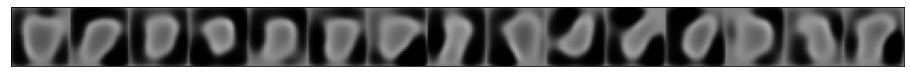

Model saved 2021-04-25_19h14_e0.pt



Epoch 1: loss = 0.08031845092773438  -----  time = 195.33892822265625
Ws: [0.5224851369857788, 0.5329868197441101, 0.5474107265472412, 0.5562861561775208, 0.5733237266540527, 0.5423593521118164]


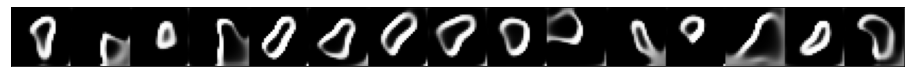


Epoch 2: loss = 0.08025336265563965  -----  time = 195.56785011291504
Ws: [0.5631465911865234, 0.5640246868133545, 0.5639190077781677, 0.5709069967269897, 0.5693641901016235, 0.5308341979980469]


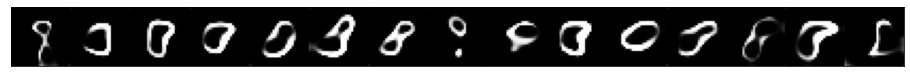


Epoch 3: loss = 0.11701834201812744  -----  time = 195.13212323188782
Ws: [0.5393333435058594, 0.5539126396179199, 0.5560911893844604, 0.556908130645752, 0.5574707984924316, 0.5143489241600037]


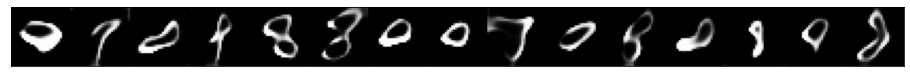


Epoch 4: loss = 0.07491707801818848  -----  time = 195.107342004776
Ws: [0.519477367401123, 0.5220348834991455, 0.5195385217666626, 0.5165661573410034, 0.5170558094978333, 0.4806617498397827]


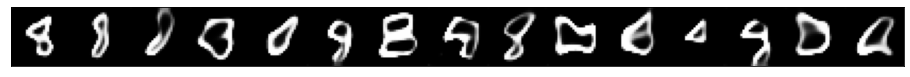


Epoch 5: loss = 0.06360089778900146  -----  time = 195.01465129852295
Ws: [0.41381990909576416, 0.37904295325279236, 0.38915497064590454, 0.3944474160671234, 0.4045182764530182, 0.33796143531799316]


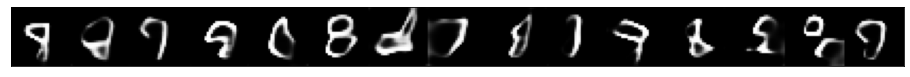


Epoch 6: loss = 0.07115018367767334  -----  time = 195.14151287078857
Ws: [0.40473103523254395, 0.4141779839992523, 0.4122627079486847, 0.40829065442085266, 0.4087756276130676, 0.38144737482070923]


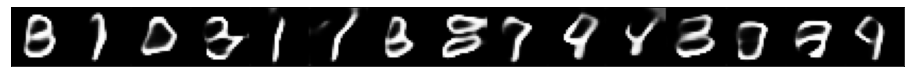


Epoch 7: loss = 0.011163175106048584  -----  time = 195.50041151046753
Ws: [0.1667998731136322, 0.1711803376674652, 0.1622440218925476, 0.17922921478748322, 0.1717994213104248, 0.16984504461288452]


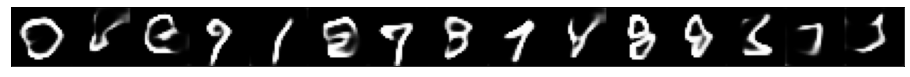


Epoch 8: loss = 0.0007180236279964447  -----  time = 196.05986642837524
Ws: [0.017987685278058052, 0.017132816836237907, 0.018333913758397102, 0.01879318617284298, 0.019961737096309662, 0.018764130771160126]


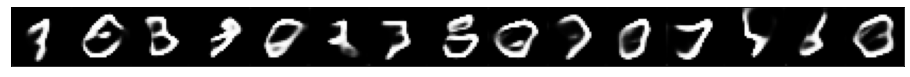


Epoch 9: loss = 0.000712081789970398  -----  time = 196.14773440361023
Ws: [0.0305072870105505, 0.03209947049617767, 0.03132937476038933, 0.030827529728412628, 0.03002748265862465, 0.03127860277891159]


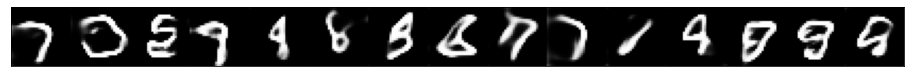


Epoch 10: loss = 0.04792428016662598  -----  time = 196.10882806777954
Ws: [0.32764220237731934, 0.3409484624862671, 0.33965444564819336, 0.327955961227417, 0.325161874294281, 0.3152559995651245]


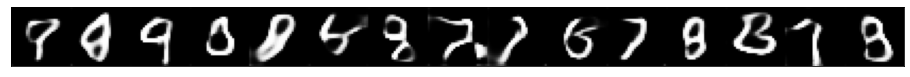


Epoch 11: loss = 0.12167268991470337  -----  time = 196.2708077430725
Ws: [0.45821070671081543, 0.42700842022895813, 0.4388582110404968, 0.4245489239692688, 0.4318173825740814, 0.3420694172382355]


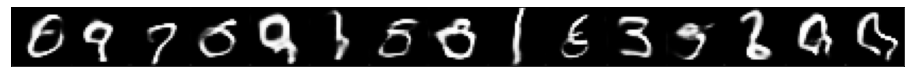


Epoch 12: loss = 0.07632136344909668  -----  time = 196.39017510414124
Ws: [0.27409642934799194, 0.3188019394874573, 0.32289475202560425, 0.3259221613407135, 0.3281225860118866, 0.3356136083602905]


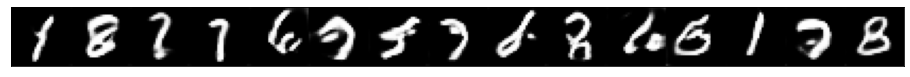


Epoch 13: loss = 0.10260647535324097  -----  time = 196.29191994667053
Ws: [0.5210102796554565, 0.5109773278236389, 0.5169105529785156, 0.5258320569992065, 0.5374882221221924, 0.47329047322273254]


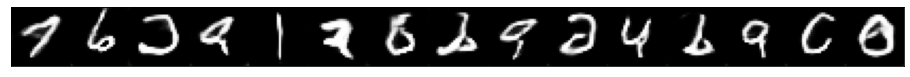


Epoch 14: loss = 0.05325895547866821  -----  time = 195.84738993644714
Ws: [0.502708911895752, 0.4986304044723511, 0.49569594860076904, 0.5088245868682861, 0.5051103830337524, 0.4747922122478485]


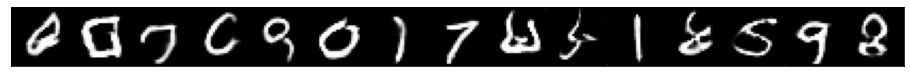

Model saved 2021-04-25_20h00_e14.pt


[0.034417495131492615,
 0.08031845092773438,
 0.08025336265563965,
 0.11701834201812744,
 0.07491707801818848,
 0.06360089778900146,
 0.07115018367767334,
 0.011163175106048584,
 0.0007180236279964447,
 0.000712081789970398,
 0.04792428016662598,
 0.12167268991470337,
 0.07632136344909668,
 0.10260647535324097,
 0.05325895547866821]

In [ ]:
# Training
gan.train(score_iter=1, epochs=15, backup_iter=15, display_iter=1)

#### Display

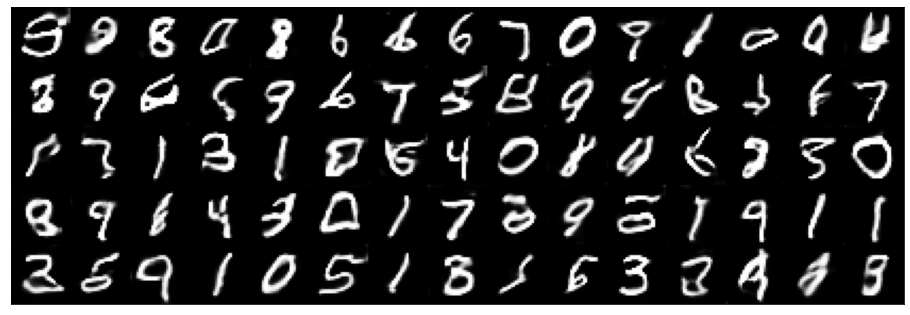

In [ ]:
# To avoid some errors if the working device is a cpu, but no training was done
gan.set_device('cpu')

# Display image_grid
gan.display(75)

### DCGAN

#### Start training, pursue training, or load a model

In [ ]:
# Specify working device
device = torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")
print(device)

cuda:0


In [ ]:
# Construct the data loader with the specified dataset, batch_size and filters
dataset = 'MNIST'
batch_size = 512
filters = []

if dataset=='MNIST':
    loader = MyDataLoader(dataset, batch_size, filters)
    img_shape = (1, 28, 28)

elif dataset=='CIFAR10':
    loader = MyDataLoader(dataset, batch_size, filters)
    img_shape = (3, 32, 32)

# Build generator and critic
generator = DCGAN_Generator(img_shape=img_shape)
critic = DCGAN_Critic(img_shape=img_shape)

In [ ]:
# Set to True if you want to load previous weights (keep training or load model)
# A list of weights will be provided bellow
if False:
    path_cri = './models/DCGAN_critic.pt'
    path_gen = './models/DCGAN_generator.pt'
    generator.load_weights(path_gen)
    critic.load_weights(path_cri)
gan = DCGAN(loader, generator, critic, device)

In [ ]:
# Training
gan.train(score_iter=1, epochs=25, backup_iter=5, display_iter=1)

#### Display

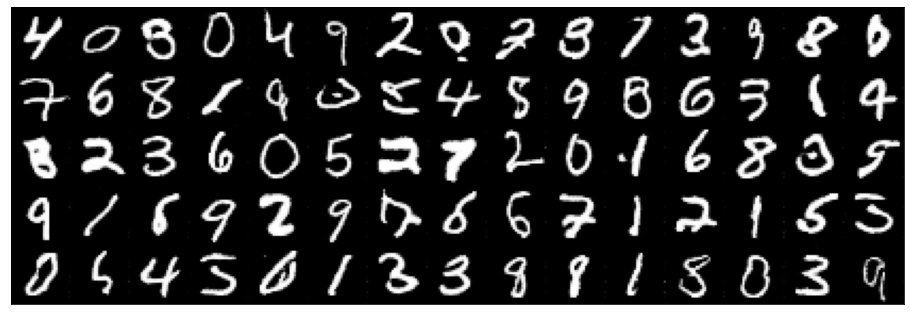

In [ ]:
# To avoid some errors if the working device is a cpu, but no training was done
gan.set_device('cpu')

# Display image_grid
gan.display(75)

## References

[1] *Improving GANs Using Optimal Transport*,
Tim Salimans, Han Zhang, Alec Radford, Dimitris Metaxas: https://arxiv.org/pdf/1803.05573.pdf

[2] *Unsupervised representation learning
with deep convolutional generative adversarial networks*,
Alec Radford, Luke Metz, Soumith Chintala: https://arxiv.org/pdf/1511.06434.pdf